In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Import necessary libraries for visualization and data handling
import matplotlib.pyplot as plt       # For plotting graphs and images
import numpy as np                    # For numerical operations
import pandas as pd                   # For handling tabular data
import seaborn as sns                 # For advanced visualizations and styling
import os                             # For interacting with the file system

# Import deep learning tools from TensorFlow Keras

# Tools for loading and transforming images
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

# Model base classes
from tensorflow.keras.models import Model, Sequential  # Model = for functional API, Sequential = for stack-based models

# Neural network layers
from tensorflow.keras.layers import (
    Dense,                  # Fully connected layer
    Input,                  # Input layer
    Dropout,                # Dropout for regularization
    GlobalAveragePooling2D, # Converts feature maps to a single vector by averaging
    Flatten,                # Flattens input to 1D
    Conv2D,                 # 2D convolutional layer
    BatchNormalization,     # Normalizes activations to improve training stability
    Activation,             # Applies activation functions like ReLU
    MaxPooling2D            # Reduces spatial dimensions (downsampling)
)

# Optimizers for training models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop  # Adam: adaptive optimizer, SGD: stochastic gradient descent, RMSprop: gradient descent variant


Displaying immages


In [9]:
picture_size=48
folder_path="/kaggle/input/face-expression-recognition-dataset/images/"

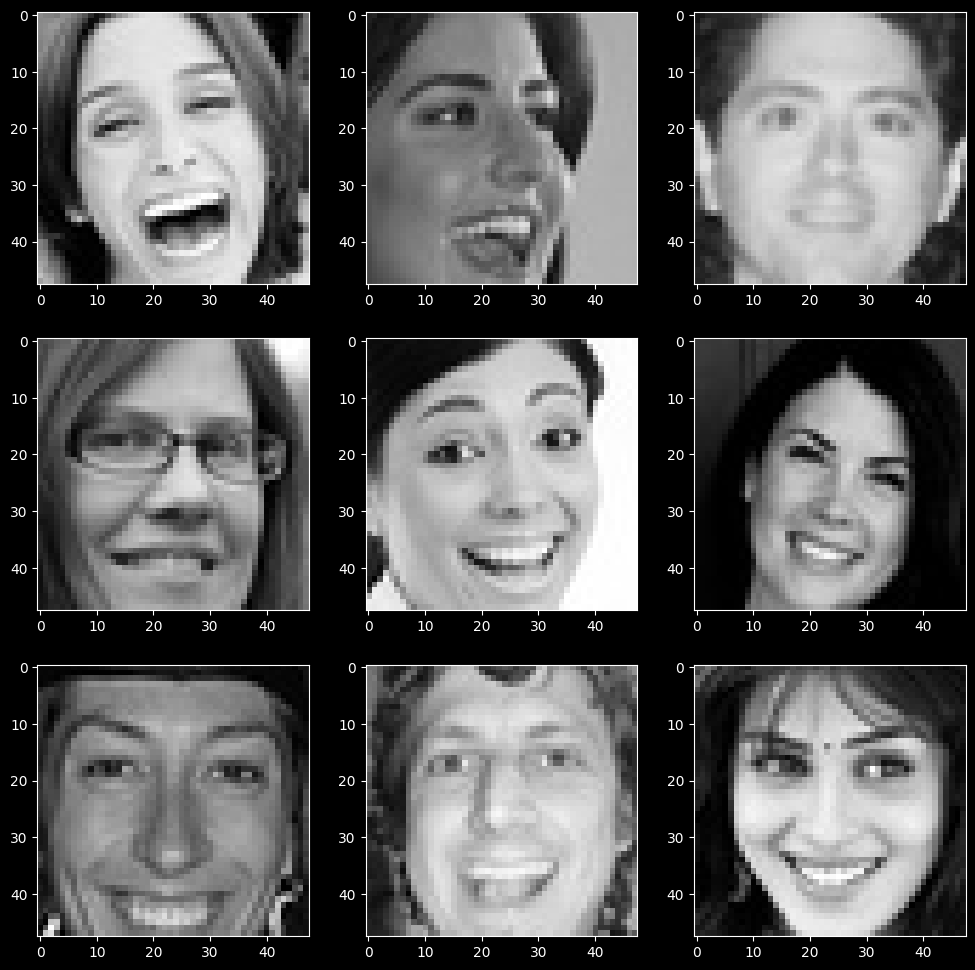

In [10]:
expression ='happy'
plt.style.use('dark_background')
plt.figure(figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path +"train/"+ expression +"/"+ 
                   os.listdir(folder_path +"train/" + expression)[i], target_size=(picture_size,picture_size))
    plt.imshow(img)
plt.show()    

Marking training and validation data

In [ ]:
# Set batch size for training and validation
batch_size = 128  # Number of images processed before the model is updated

# Create ImageDataGenerator objects for training and validation sets
# These are used to load and preprocess images from directories
datagen_train = ImageDataGenerator()  # No augmentation applied here (can be customized)
datagen_val = ImageDataGenerator()    # Validation set typically doesn't need augmentation

# Load training data from directory
train_set = datagen_train.flow_from_directory(
    folder_path + "train",                # Path to training data folder
    target_size=(picture_size, picture_size),  # Resize all images to this size
    color_mode="grayscale",              # Convert images to grayscale (1 channel)
    batch_size=batch_size,               # Number of images to return in each batch
    class_mode='categorical',            # Multi-class labels (one-hot encoded)
    shuffle=True                         # Shuffle training data for each epoch
)

# Load validation (testing) data from directory
test_set = datagen_val.flow_from_directory(
    folder_path + "validation",          # Path to validation data folder
    target_size=(picture_size, picture_size),  # Resize all images to same size
    color_mode="grayscale",              # Grayscale images
    batch_size=batch_size,               # Number of images per batch
    class_mode='categorical',            # Multi-class classification (one-hot labels)
    shuffle=False                        # No shuffling to maintain order during evaluation
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


Model building

In [ ]:
# Define number of output emotion classes
no_of_classes = 7  # e.g., sadness, anger, happiness, etc.

# Initialize a Sequential model
model = Sequential()

# ------------------------ 1st Convolutional Layer ------------------------
model.add(Conv2D(64, (3, 3), padding="same", input_shape=(48, 48, 1)))  # 64 filters of 3x3, grayscale input
model.add(BatchNormalization())       # Normalize activations to speed up convergence
model.add(Activation('relu'))         # Apply ReLU activation
model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample feature map (reduces size by half)
model.add(Dropout(0.25))              # Dropout to reduce overfitting

# ------------------------ 2nd Convolutional Layer ------------------------
model.add(Conv2D(128, (5, 5), padding='same'))  # 128 filters of 5x5
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# ------------------------ 3rd Convolutional Layer ------------------------
model.add(Conv2D(512, (3, 3), padding='same'))  # 512 filters of 3x3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# ------------------------ 4th Convolutional Layer ------------------------
model.add(Conv2D(512, (3, 3), padding='same'))  # Repeat of previous layer
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# ------------------------ Flatten Layer ------------------------
model.add(Flatten())  # Flatten output of CNN into a 1D vector for dense layers

# ------------------------ Fully Connected Layer 1 ------------------------
model.add(Dense(256))             # Dense layer with 256 neurons
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# ------------------------ Fully Connected Layer 2 ------------------------
model.add(Dense(512))             # Dense layer with 512 neurons
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# ------------------------ Output Layer ------------------------
model.add(Dense(no_of_classes, activation='softmax'))  # Final layer: softmax for multi-class classification

# ------------------------ Compilation ------------------------
opt = Adam(learning_rate=0.0001)  # Adam optimizer with small learning rate
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the model

# ------------------------ Summary ------------------------
model.summary()  # Print the model architecture


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

Fitting the model with training and validation data(training the  model using the training data and at the same time checking its performance using the validation data after each training cycle)

In [ ]:
# Import useful Keras callbacks for training optimization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ---------------- ModelCheckpoint ----------------
# Saves the model with the best validation accuracy during training
checkpoint = ModelCheckpoint(
    "./model.h5",                # Path to save the model
    monitor='val_acc',           # Metric to monitor (validation accuracy)
    verbose=1,                   # Print message when saving
    save_best_only=True,         # Only save if model is improved
    mode='max'                   # Maximize the monitored metric
)

# ---------------- EarlyStopping ----------------
# Stop training early if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',          # Watch validation loss
    min_delta=0,                 # Minimum change to qualify as improvement
    patience=3,                  # Stop after 3 epochs of no improvement
    verbose=1,                   # Print when stopping
    restore_best_weights=True    # Restore model weights from the best epoch
)

# ---------------- ReduceLROnPlateau ----------------
# Reduce learning rate when a metric has stopped improving
reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',          # Watch validation loss
    factor=0.2,                  # Reduce learning rate by this factor
    patience=3,                  # Wait 3 epochs before reducing
    verbose=1,                   # Print message on learning rate reduction
    min_delta=0.0001             # Minimum change to qualify as improvement
)

# ---------------- Callback List ----------------
# Combine all callbacks into a list for use during model training
callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# ---------------- Number of Training Epochs ----------------
epochs = 48  # Total number of training epochs. ,, epoch refers to one complete pass through the entire training dataset.


In [ ]:
history = model.fit(
    train_set,  # 👈 Training data loaded using flow_from_directory (with preprocessing and augmentation)
    
    steps_per_epoch = train_set.n // train_set.batch_size,  
    # 👈 Defines how many batches to run per epoch. It ensures the entire training dataset is used once per epoch.
    # train_set.n is total number of training images, train_set.batch_size is images per batch.

    epochs = epochs,  
    # 👈 Total number of times the entire training dataset will be passed through the model.

    validation_data = test_set,  
    # 👈 Validation dataset for evaluating the model after each epoch (not used for training).

    validation_steps = test_set.n // test_set.batch_size,  
    # 👈 Number of validation batches to run after each epoch.
    # It ensures all validation samples are evaluated.

    callbacks = callbacks_list  
    # 👈 List of callbacks:
    # - EarlyStopping: Stops training if validation loss doesn’t improve.
    # - ModelCheckpoint: Saves the model when validation accuracy improves.
    # - ReduceLROnPlateau: Lowers learning rate if validation loss plateaus.
)


Epoch 1/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 668s 3s/step - accuracy: 0.3234 - loss: 1.7702 - val_accuracy: 0.3351 - val_loss: 1.7603 - learning_rate: 1.0000e-04
Epoch 2/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.4062 - loss: 1.6743 - val_accuracy: 0.3361 - val_loss: 1.7565 - learning_rate: 1.0000e-04
Epoch 3/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 669s 3s/step - accuracy: 0.3561 - loss: 1.6847 - val_accuracy: 0.3759 - val_loss: 1.6576 - learning_rate: 1.0000e-04
Epoch 4/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.4062 - loss: 1.5197 - val_accuracy: 0.3770 - val_loss: 1.6575 - learning_rate: 1.0000e-04
Epoch 5/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 672s 3s/step - accuracy: 0.3757 - loss: 1.6154 - val_accuracy: 0.4074 - val_loss: 1.5607 - learning_rate: 1.0000e-04
Epoch 6/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - accuracy: 0.3594 - loss: 1.5895 - val_accuracy: 0.4044 - val_loss: 1.5716 - learning_rate: 1.0000e-04
Epoch 7/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step

In [45]:
model.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 13,428,247 (51.22 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

 Optimizer params: 8,949,520 (34.14 MB)

In [46]:
model.save("/kaggle/working/model.h5")


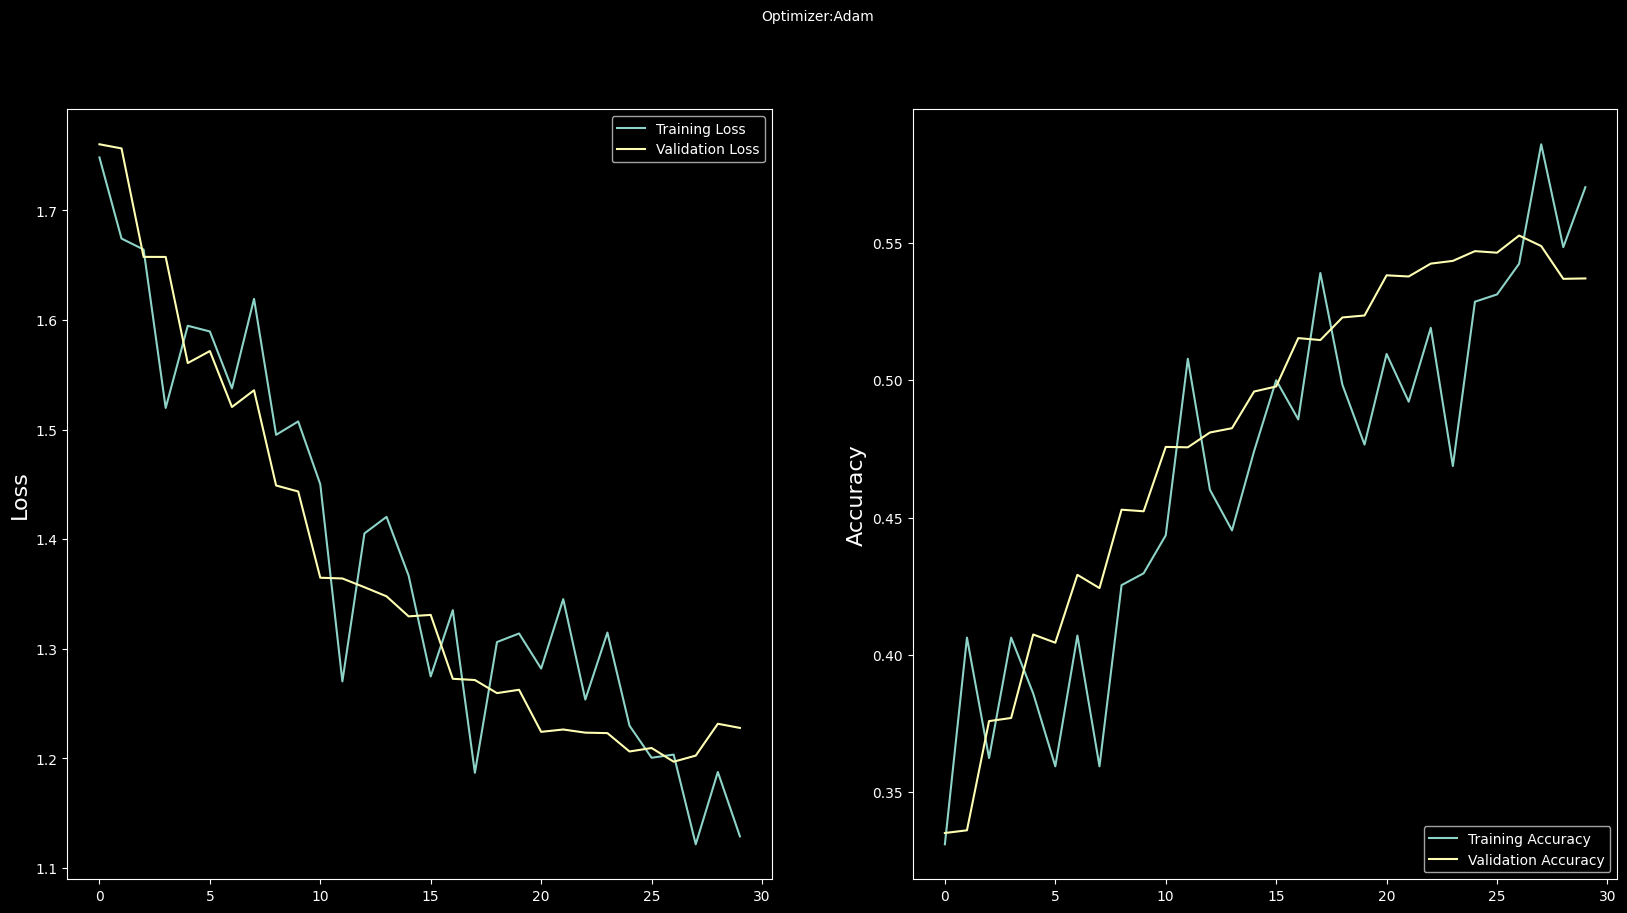

In [49]:
# plotting accuracy and loss
plt.style.use('dark_background')
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.suptitle('Optimizer:Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy',fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()